In [1]:
import os
import sys

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, Sequential, optimizers, layers

### 1. 准备数据

In [2]:
(x_train_all, y_train_all), (x_test, y_test) = datasets.fashion_mnist.load_data()
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print(x_valid.shape, y_valid.shape)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(5000, 28, 28) (5000,)
(55000, 28, 28) (55000,)
(10000, 28, 28) (10000,)


In [3]:
# 数据归一化处理
# x = (x - u) / std

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
# scaler 接受数据的维度最好 <= 2
scaler.fit(x_train.reshape(-1, 1))
x_train_scaled = scaler.transform(x_train.reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.transform(
    x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.transform(
    x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)

In [4]:
print(np.max(x_train_scaled), np.min(x_train_scaled))

2.023143278665243 -0.8105136544337038


### 2. 构建模型

In [5]:
model = keras.models.Sequential([
    layers.Flatten(input_shape=(28, 28)),
    layers.Dense(300, activation='relu'),
    layers.Dense(100, activation='relu'),
    layers.Dense(10, activation='softmax')
])

# relu: y = max(0, x)
# softmax: 将向量变成概率分布. x = [x1, x2, x3], 
#          y = [e^x1/sum, e^x2/sum, e^x3/sum], sum = e^x1 + e^x2 + e^x3
optimizer = optimizers.SGD(learning_rate=0.001)
# reason for sparse: y->index. y->one_hot->[] 
# 通过 sparse 可以使 y 变为向量
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
             metrics=["accuracy"])

- `callbacks: utilities called at certain points during model training.`
    - `TensorBoard: Enable visualizations for TensorBoard.`
    - `ModelCheckpoint: Save the model after every epoch.`
    - `Earlystopping: Stop training when a monitored quantity has stopped improving.`

In [6]:
logdir = 'callbacks'
if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir, "fashion_mnist_model.h5").encode('ISO-8859-1')

callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only= True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3)
]
history = model.fit(x_train_scaled, y_train, epochs=5, validation_data=(x_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/5
55000/55000 [==============================] - 9s 164us/sample - loss: 0.8856 - accuracy: 0.7148 - val_loss: 0.6087 - val_accuracy: 0.7998
Epoch 2/5
55000/55000 [==============================] - 7s 124us/sample - loss: 0.5725 - accuracy: 0.8015 - val_loss: 0.5226 - val_accuracy: 0.8256
Epoch 3/5
55000/55000 [==============================] - 8s 154us/sample - loss: 0.5107 - accuracy: 0.8205 - val_loss: 0.4806 - val_accuracy: 0.8358
Epoch 4/5
55000/55000 [==============================] - 9s 170us/sample - loss: 0.4767 - accuracy: 0.8307 - val_loss: 0.4578 - val_accuracy: 0.8446
Epoch 5/5
55000/55000 [==============================] - 9s 158us/sample - loss: 0.4533 - accuracy: 0.8393 - val_loss: 0.4406 - val_accuracy: 0.8502


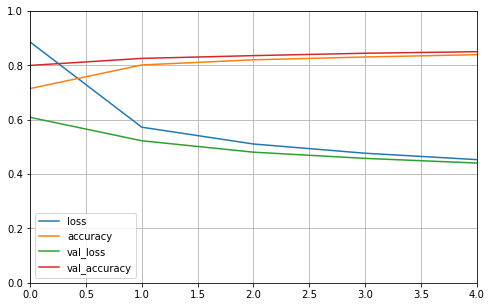

In [7]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)

plot_learning_curves(history)

In [8]:
model.evaluate(x_test_scaled, y_test, verbose=0)

[0.4796301429271698, 0.8267]